Entropy difference is large for Sand Fraction. Adjusting max bandwidth...
New max bandwidth: 0.004296875
Entropy difference is large for Water Saturation. Adjusting max bandwidth...
New max bandwidth: 0.004726562500000001


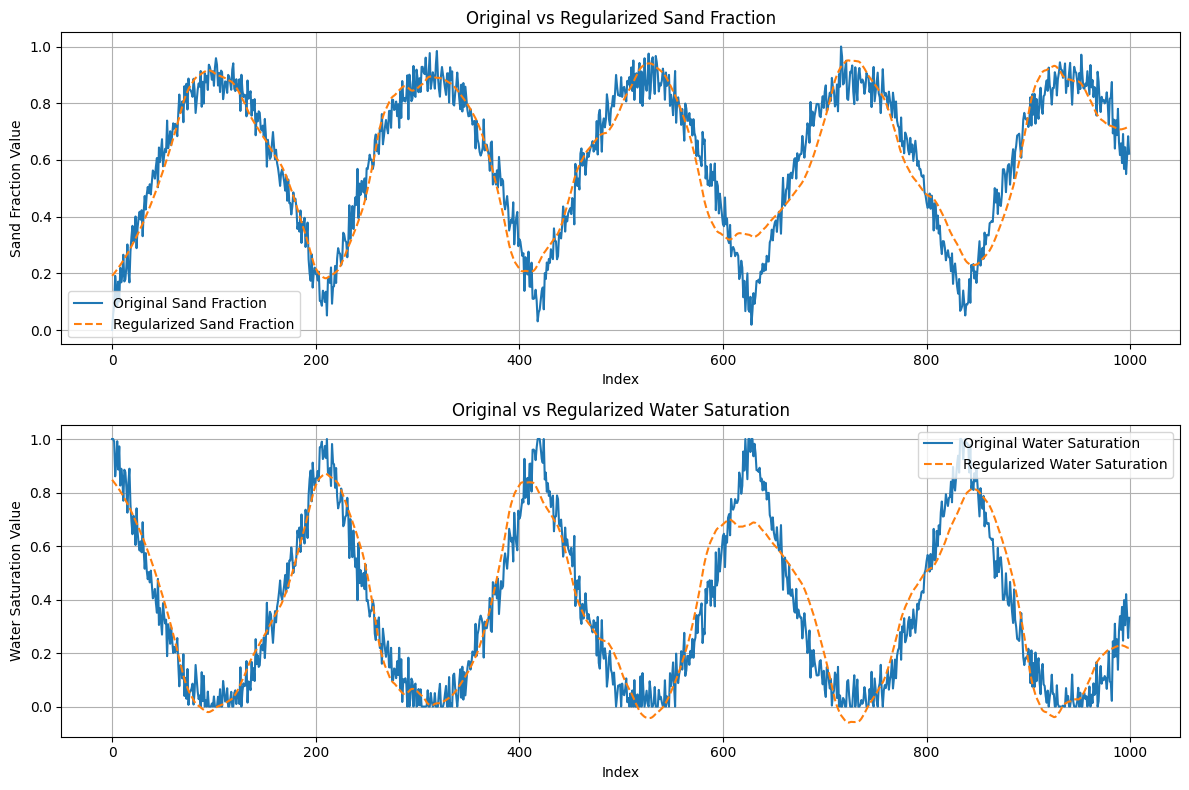

Regularized target signals processed successfully.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from scipy.fft import fft, ifft
from scipy.signal import welch

# Function to compute the Power Spectral Density (PSD)
def compute_psd(signal):
    if len(signal) < 2:
        raise ValueError("Signal length is too short for PSD calculation.")
    freq, psd = welch(signal, nperseg=min(256, len(signal)//2))
    return freq, psd

# Function to compute the Fourier Transform (FT) of a signal
def compute_fft(signal):
    freq = np.fft.fftfreq(len(signal))  # Relative frequencies
    spectrum = np.fft.fft(signal)
    return freq, spectrum

# Function to compute the Inverse Fourier Transform (IFT) of a truncated spectrum
def compute_ifft(truncated_spectrum):
    return np.real(ifft(truncated_spectrum))

# Function to compute the entropy of a signal
def compute_entropy(signal):
    # Normalize the signal
    signal = np.abs(signal) / np.sum(np.abs(signal))
    # Compute the entropy
    return -np.sum(signal * np.log(signal + 1e-10))  # Add small value to avoid log(0)

# Function to adjust max bandwidth if entropy difference is too large
def adjust_max_bandwidth(current_max_bandwidth, adjustment_factor=0.1):
    return current_max_bandwidth * (1 + adjustment_factor)

# Function to regularize target signal using wavelet decomposition
def wavelet_decomposition_regularization(target_signal, wavelet='db4', level=6):
    # Decompose the signal using wavelet transform
    coeffs = pywt.wavedec(target_signal, wavelet, level=level)
    
    # Truncate detailed coefficients (zero out the detailed coefficients)
    coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]  # Retain only the approximation at the last level
    
    # Reconstruct the signal from the modified coefficients
    regularized_signal = pywt.waverec(coeffs, wavelet)
    
    return regularized_signal

# Main function to process signals and apply regularization
def process_signals(predictor_csv, target_csv):
    # Load predictor and target data
    predictor_data = pd.read_csv(predictor_csv)
    target_data = pd.read_csv(target_csv)
    target_data = target_data.drop('Depth (m)', axis=1, inplace=False)  # Remove non-numeric columns like depth
    
    # Combine predictor signals (impedance, frequency, and amplitude)
    combined_predictor_signal = predictor_data.values.flatten()

    # Step 1: Compute PSD to determine the max bandwidth from the predictor signal
    try:
        freq_predictor, psd_predictor = compute_psd(combined_predictor_signal)
    except ValueError as e:
        print(f"Error: {e}")
        return None

    # Check for non-zero peak in PSD
    max_psd_freq = freq_predictor[np.argmax(psd_predictor)]
    if np.isnan(max_psd_freq):
        print("No significant frequencies detected in the predictor signal.")
        return None

    max_bandwidth_predictor = max_psd_freq  # Peak frequency in PSD

    # Step 2: Regularize each target variable based on wavelet decomposition
    regularized_signals = {}
    for column in target_data.columns:
        target_signal = target_data[column].values
        regularized_target_signal = wavelet_decomposition_regularization(target_signal)

        # Compare entropies of the predictor and regularized target signals
        entropy_predictor = compute_entropy(combined_predictor_signal)
        entropy_regularized_target = compute_entropy(regularized_target_signal)

        # Step 3: If entropy difference is large, adjust max_bandwidth and repeat
        if abs(entropy_regularized_target - entropy_predictor) > 0.05:  # Threshold for entropy difference
            print(f"Entropy difference is large for {column}. Adjusting max bandwidth...")
            max_bandwidth_predictor = adjust_max_bandwidth(max_bandwidth_predictor)
            print(f"New max bandwidth: {max_bandwidth_predictor}")
            # Reapply regularization with the new max bandwidth
            regularized_target_signal = wavelet_decomposition_regularization(target_signal)

        # Store the regularized signals for plotting
        regularized_signals[column] = regularized_target_signal

    # Step 4: Plot the original and regularized target signals for each variable
    plt.figure(figsize=(12, 8))
    for i, (column, regularized_signal) in enumerate(regularized_signals.items(), 1):
        plt.subplot(len(regularized_signals), 1, i)
        original_signal = target_data[column].values
        plt.plot(original_signal, label=f"Original {column}")
        plt.plot(regularized_signal, label=f"Regularized {column}", linestyle='--')
        plt.title(f"Original vs Regularized {column}")
        plt.xlabel("Index")
        plt.ylabel(f"{column} Value")
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()

    return regularized_signals

# Example usage
if __name__ == "__main__":
    predictor_csv = r"C:\Users\aryan\OneDrive\Desktop\Reservoir Classification\combined_signal.csv"  # Modify with actual path
    target_csv = r"C:\Users\aryan\OneDrive\Desktop\Reservoir Classification\well_normalised.csv"  # Modify with actual path
    regularized_signals = process_signals(predictor_csv, target_csv)
    if regularized_signals is not None:
        print("Regularized target signals processed successfully.")
    else:
        print("Regularization failed.")


Entropy difference is large for Sand Fraction. Adjusting max bandwidth...
New max bandwidth: 0.004296875
Entropy difference is large for Water Saturation. Adjusting max bandwidth...
New max bandwidth: 0.004726562500000001


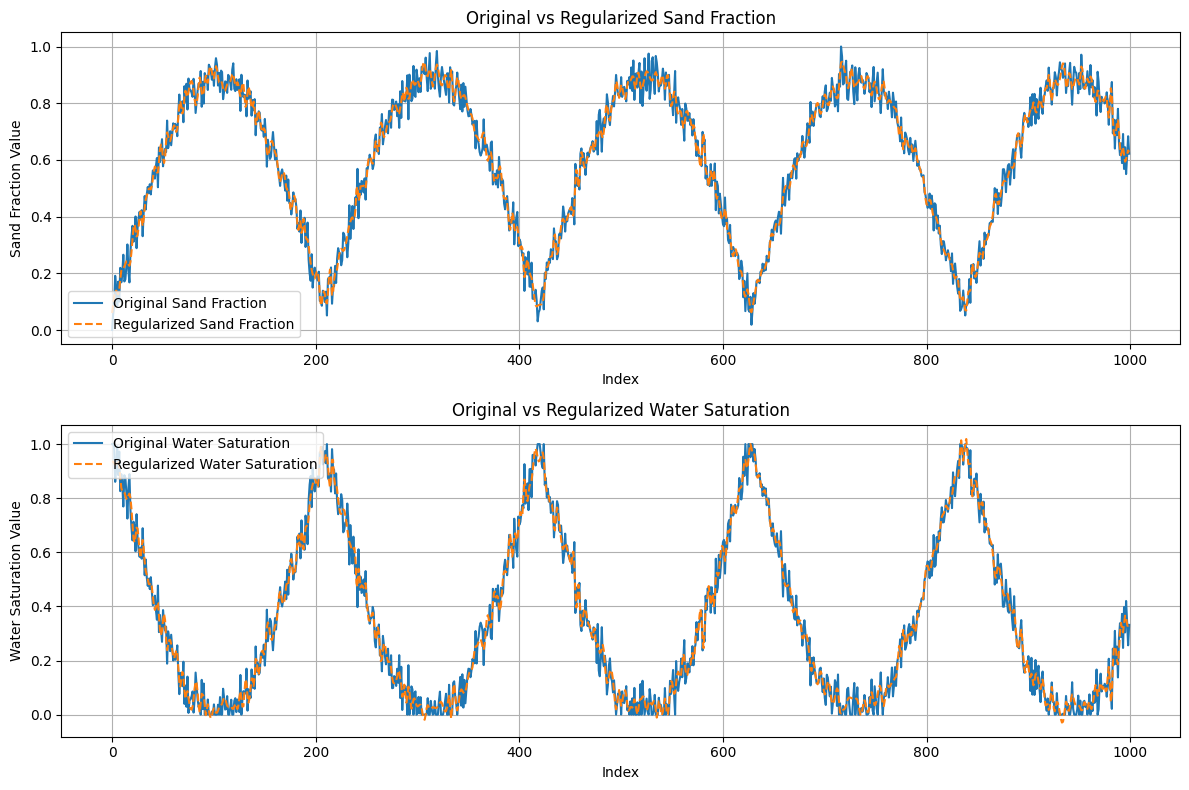

Regularized target signals processed successfully.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import EMD
from scipy.fft import fft, ifft
from scipy.signal import welch

# Function to compute the Power Spectral Density (PSD)
def compute_psd(signal):
    if len(signal) < 2:
        raise ValueError("Signal length is too short for PSD calculation.")
    freq, psd = welch(signal, nperseg=min(256, len(signal)//2))
    return freq, psd

# Function to compute the Fourier Transform (FT) of a signal
def compute_fft(signal):
    freq = np.fft.fftfreq(len(signal))  # Relative frequencies
    spectrum = np.fft.fft(signal)
    return freq, spectrum

# Function to compute the Inverse Fourier Transform (IFT) of a truncated spectrum
def compute_ifft(truncated_spectrum):
    return np.real(ifft(truncated_spectrum))

# Function to compute the entropy of a signal
def compute_entropy(signal):
    # Normalize the signal
    signal = np.abs(signal) / np.sum(np.abs(signal))
    # Compute the entropy
    return -np.sum(signal * np.log(signal + 1e-10))  # Add small value to avoid log(0)

# Function to adjust max bandwidth if entropy difference is too large
def adjust_max_bandwidth(current_max_bandwidth, adjustment_factor=0.1):
    return current_max_bandwidth * (1 + adjustment_factor)

# Function to regularize target signal using EMD
def emd_regularization(target_signal, truncate_imfs=1):
    # Initialize the EMD object
    emd = EMD()
    
    # Decompose the target signal using EMD
    imfs = emd(target_signal)
    
    # Truncate the high-frequency IMFs (keep only the first few IMFs)
    truncated_imfs = imfs[truncate_imfs:]  # Keep only the IMFs beyond the truncated ones
    
    # Reconstruct the signal from the truncated IMFs
    regularized_signal = np.sum(truncated_imfs, axis=0)
    
    return regularized_signal

# Main function to process signals and apply regularization
def process_signals(predictor_csv, target_csv):
    # Load predictor and target data
    predictor_data = pd.read_csv(predictor_csv)
    target_data = pd.read_csv(target_csv)
    target_data = target_data.drop('Depth (m)', axis=1, inplace=False)  # Remove non-numeric columns like depth
    
    # Combine predictor signals (impedance, frequency, and amplitude)
    combined_predictor_signal = predictor_data.values.flatten()

    # Step 1: Compute PSD to determine the max bandwidth from the predictor signal
    try:
        freq_predictor, psd_predictor = compute_psd(combined_predictor_signal)
    except ValueError as e:
        print(f"Error: {e}")
        return None

    # Check for non-zero peak in PSD
    max_psd_freq = freq_predictor[np.argmax(psd_predictor)]
    if np.isnan(max_psd_freq):
        print("No significant frequencies detected in the predictor signal.")
        return None

    max_bandwidth_predictor = max_psd_freq  # Peak frequency in PSD

    # Step 2: Regularize each target variable based on EMD decomposition
    regularized_signals = {}
    for column in target_data.columns:
        target_signal = target_data[column].values
        regularized_target_signal = emd_regularization(target_signal)

        # Compare entropies of the predictor and regularized target signals
        entropy_predictor = compute_entropy(combined_predictor_signal)
        entropy_regularized_target = compute_entropy(regularized_target_signal)

        # Step 3: If entropy difference is large, adjust max_bandwidth and repeat
        if abs(entropy_regularized_target - entropy_predictor) > 0.05:  # Threshold for entropy difference
            print(f"Entropy difference is large for {column}. Adjusting max bandwidth...")
            max_bandwidth_predictor = adjust_max_bandwidth(max_bandwidth_predictor)
            print(f"New max bandwidth: {max_bandwidth_predictor}")
            # Reapply regularization with the new max bandwidth
            regularized_target_signal = emd_regularization(target_signal)

        # Store the regularized signals for plotting
        regularized_signals[column] = regularized_target_signal

    # Step 4: Plot the original and regularized target signals for each variable
    plt.figure(figsize=(12, 8))
    for i, (column, regularized_signal) in enumerate(regularized_signals.items(), 1):
        plt.subplot(len(regularized_signals), 1, i)
        original_signal = target_data[column].values
        plt.plot(original_signal, label=f"Original {column}")
        plt.plot(regularized_signal, label=f"Regularized {column}", linestyle='--')
        plt.title(f"Original vs Regularized {column}")
        plt.xlabel("Index")
        plt.ylabel(f"{column} Value")
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()

    return regularized_signals

# Example usage
if __name__ == "__main__":
    predictor_csv = r"C:\Users\aryan\OneDrive\Desktop\Reservoir Classification\combined_signal.csv"  # Modify with actual path
    target_csv = r"C:\Users\aryan\OneDrive\Desktop\Reservoir Classification\well_normalised.csv"  # Modify with actual path
    regularized_signals = process_signals(predictor_csv, target_csv)
    if regularized_signals is not None:
        print("Regularized target signals processed successfully.")
    else:
        print("Regularization failed.")
